# Ticino Covid - Data Analysis and modelling

Modeling SARS-CoV-2 epidemic in Ticino, Switzerland as a quasi-reaction system from scratch.


In [1]:
# Import libraries
import pandas as pd
import numpy as np

## Loading data

In [19]:
# Load dataset using pandas
df = pd.read_csv('https://raw.githubusercontent.com/openZH/covid_19/master/fallzahlen_kanton_total_csv_v2/COVID19_Fallzahlen_Kanton_TI_total.csv')

# Extract only required columns: cases, recovers, and deaths
COLUMNS = [
  "date",
  "ncumul_conf",
  "ncumul_released",
  "ncumul_deceased",
]
df = df[COLUMNS]

# Select only rows with data
last_nan_index = df["ncumul_released"].last_valid_index()
df = df.iloc[:last_nan_index + 1]

# Rename columns
df_model = df.rename(columns={
  "date": "Date",
  "ncumul_conf": "I",
  "ncumul_released": "R",
  "ncumul_deceased": "D",
})

df_model

,Date,I,R,D
0,2020-02-25,0,0.0,0
1,2020-02-26,1,0.0,0
2,2020-02-27,1,0.0,0
3,2020-02-28,1,0.0,0
4,2020-02-29,2,0.0,0
...,...,...,...,...
437,2021-06-02,33088,3402.0,995
438,2021-06-03,33099,3406.0,995
439,2021-06-04,33109,3409.0,995
440,2021-06-05,33116,3410.0,995


## Compartmental model

$$
\begin{align}
S + I &\xrightarrow{\beta_1} 2I \\
I &\xrightarrow{\beta_2} R \\
I &\xrightarrow{\beta_3} D \\
R &\xrightarrow{\beta_4} S \\
\end{align}
$$

In [3]:
# Products matrix (S, I, R, D)
P = np.array([
  [0, 2, 0, 0],
  [0, 0, 1, 0],
  [0, 0, 0, 1],
  [1, 0, 0, 0],
])

# Reactants matrix (S, I, R, D)
R = np.array([
  [1, 1, 0, 0],
  [0, 1, 0, 0],
  [0, 1, 0, 0],
  [0, 0, 1, 0],
])

# Net effect matrix
V = P - R

print("Net effect matrix")
print(V)

Net effect matrix
[[-1  1  0  0]
 [ 0 -1  1  0]
 [ 0 -1  0  1]
 [ 1  0 -1  0]]


## Restructuring data

In [23]:
# Compute the number of active cases 
df_model["I"] = df_model["I"] - df_model["R"] - df_model["D"]

# Add new column for total population
total_ticino_population_2020 = 345707

# Compute the total population
df_model.loc[0, "N"] = total_ticino_population_2020
df_model.loc[:, "N"] = total_ticino_population_2020 - df_model["D"]

# Compute the number of susceptible people at each time step
  # Assume that the number of births is equal to the number of deaths (deaths are not considered in the model)
df_model["S"] = df_model["N"] - df_model["I"] - df_model["R"]
df_model

,Date,I,R,D,ACTIVE,N,S
0,2020-02-25,0.0,0.0,0,0.0,345707.0,345707.0
1,2020-02-26,1.0,0.0,0,1.0,345707.0,345706.0
2,2020-02-27,1.0,0.0,0,1.0,345707.0,345706.0
3,2020-02-28,1.0,0.0,0,1.0,345707.0,345706.0
4,2020-02-29,2.0,0.0,0,2.0,345707.0,345705.0
...,...,...,...,...,...,...,...
437,2021-06-02,28691.0,3402.0,995,28691.0,344712.0,312619.0
438,2021-06-03,28698.0,3406.0,995,28698.0,344712.0,312608.0
439,2021-06-04,28705.0,3409.0,995,28705.0,344712.0,312598.0
440,2021-06-05,28711.0,3410.0,995,28711.0,344712.0,312591.0


## Visualization

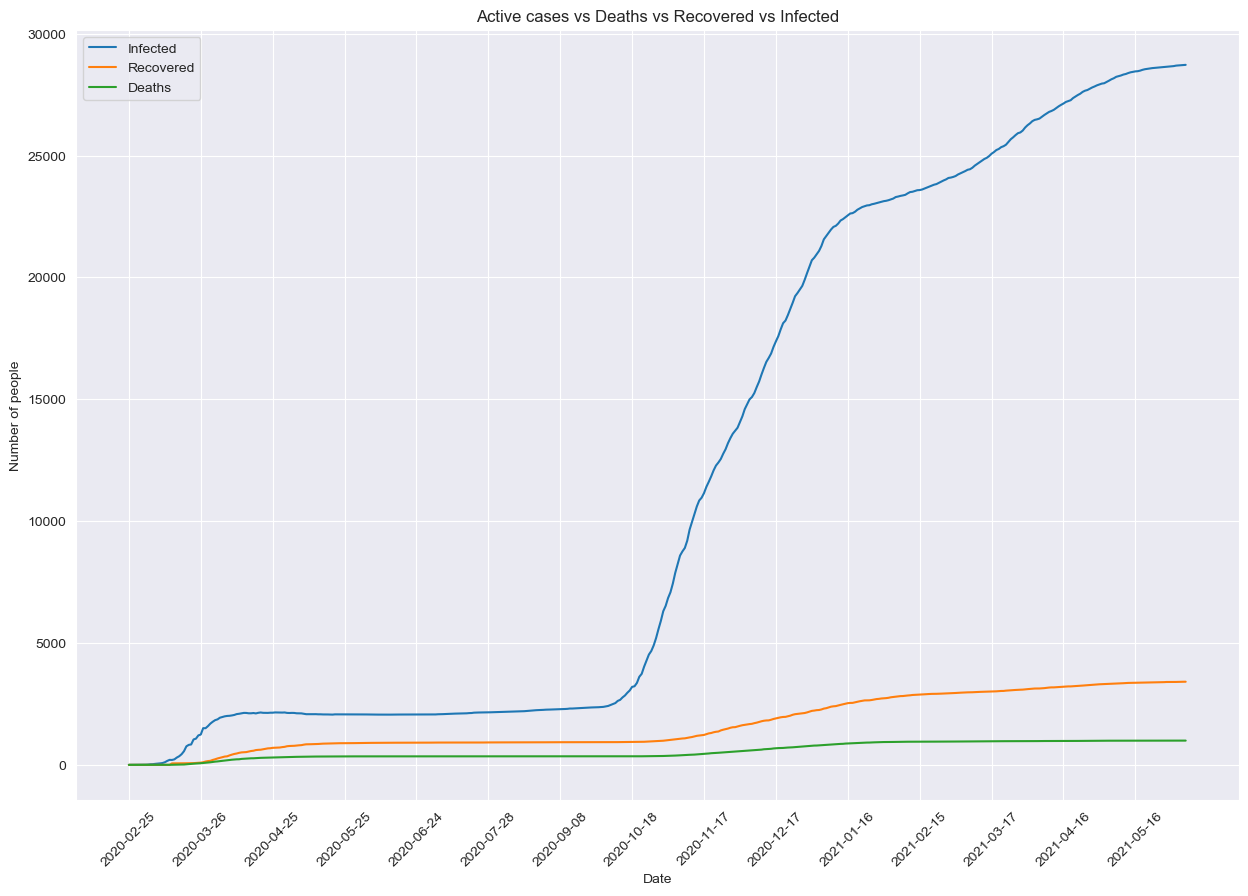

In [18]:
# Active cases vs Deaths vs Recovered vs Infected

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))

sns.lineplot(data=df_test, x="Date", y="I", label="Infected")
sns.lineplot(data=df_test, x="Date", y="R", label="Recovered")
sns.lineplot(data=df_test, x="Date", y="D", label="Deaths")

plt.title("Active cases vs Deaths vs Recovered vs Infected")
plt.ylabel("Number of people")
plt.xlabel("Date")

# Adjust ticks (every month)
plt.xticks(np.arange(0, len(df_test), 30), rotation=45)
plt.legend()

plt.show()

## Fitting the model

In [15]:
deltas = pd.DataFrame({
  "delta_S": df_test["S"].diff(),
  "delta_I": df_test["I"].diff(),
  "delta_R": df_test["R"].diff(),
  "delta_D": df_test["D"].diff(),
})

# Set the first row to 0
deltas.loc[0, :] = 0
deltas

,delta_S,delta_I,delta_R,delta_D
0,0.0,0.0,0.0,0.0
1,-1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,-1.0,1.0,0.0,0.0
...,...,...,...,...
437,-20.0,20.0,0.0,0.0
438,-11.0,7.0,4.0,0.0
439,-10.0,7.0,3.0,0.0
440,-7.0,6.0,1.0,0.0
